<a href="https://colab.research.google.com/github/fun-math/Team-6-ML-subsystem/blob/master/model1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import random
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
colours=['Green','Navy_Blue','Cyan','Red','Yellow','Brown','Black','Grey']
h=48
b=64

# Initial Data Processing

In [7]:
%cd '/content/drive/My Drive/Images'

/content/drive/.shortcut-targets-by-id/1imAlxk4WJhky2T06ANjkfoIGZY7vl8zX/Images


In [8]:
def load(img_name):
  img=cv2.imread(img_name,1)
  img=cv2.resize(img,(960,540))
  img_new=img[106:488,245:754,:]
  img_new=cv2.resize(img_new,(b,h))
  return img_new


In [9]:
m_train=0
for colour in colours :
  filenames=glob.glob('Torus_'+colour+'/*.png')
  m_train+=len(filenames)

train_X=np.zeros([m_train,h,b,3])
train_y=np.zeros([m_train,1])

ind=0
for i in range(8):
  filenames=glob.glob('Torus_'+colours[i]+'/*.png')
  for image_name in filenames :
    train_X[ind]=load(image_name)
    train_y[ind]=i
    ind+=1



m_valid=0
for colour in colours :
  filenames=glob.glob('Torus_'+colour+'/Valid/*')
  m_valid+=len(filenames)

valid_X=np.zeros([m_valid,h,b,3])
valid_y=np.zeros([m_valid,1])

ind=0
for i in range(8):
  filenames=glob.glob('Torus_'+colours[i]+'/Valid/*')
  for image_name in filenames :
    valid_X[ind]=load(image_name)
    valid_y[ind]=i
    ind+=1

In [10]:
print(len(valid_y),len(train_y))

127 320


In [11]:
train_data_gen=ImageDataGenerator(
    height_shift_range=0.1,
    width_shift_range=0.1,
    rotation_range=50,                                                
    zoom_range=[0.8,1.2],                       
)

valid_data_gen=ImageDataGenerator(
    height_shift_range=0.05,
    width_shift_range=0.05,
    rotation_range=50,                                                
    #zoom_range=[0.8,1.2]                       
)

In [12]:
m_train=len(train_y)
factor=200

X_train=np.zeros([factor*m_train,h,b,3])                                
y_train=np.zeros([factor*m_train,1])
for i in range(factor):                                                    
  it=train_data_gen.flow(train_X,train_y,batch_size=m_train)                        
  temp=next(it)
  X_train[i*m_train:(i+1)*m_train,:,:,:]=temp[0]                                 
  y_train[i*m_train:(i+1)*m_train,:]=temp[1]  

factor=20
m_valid=len(valid_y)
factor=5
X_valid=np.zeros([factor*m_valid,h,b,3])                                
y_valid=np.zeros([factor*m_valid,1])
for i in range(factor):                                                    
  it=valid_data_gen.flow(valid_X,valid_y,batch_size=m_valid)                        
  temp=next(it)
  X_valid[i*m_valid:(i+1)*m_valid,:,:,:]=temp[0]                                 
  y_valid[i*m_valid:(i+1)*m_valid,:]=temp[1]

In [13]:
pos=np.arange(len(y_train))
np.random.shuffle(pos)          
X_train=X_train[pos]
y_train=y_train[pos]

pos=np.arange(len(y_valid))
np.random.shuffle(pos)          
X_valid=X_valid[pos]
y_valid=y_valid[pos]

In [14]:
%cd '/content/drive/My Drive/Data_for_Model1b'

np.save('X_train',X_train)
np.save('y_train',y_train)
np.save('X_valid',X_valid)
np.save('y_valid',y_valid)

/content/drive/My Drive/Data_for_Model1b


# Load processed data

In [3]:
%cd '/content/drive/My Drive/Data_for_Model1b'

X_train=np.load('X_train.npy')
y_train=np.load('y_train.npy')
X_valid=np.load('X_valid.npy')
y_valid=np.load('y_valid.npy')

/content/drive/.shortcut-targets-by-id/1deNr7eN1qDWU-XvAQGWtSZn6meE_WHre/Project_Data/Task_1b


# Quick peek into some examples

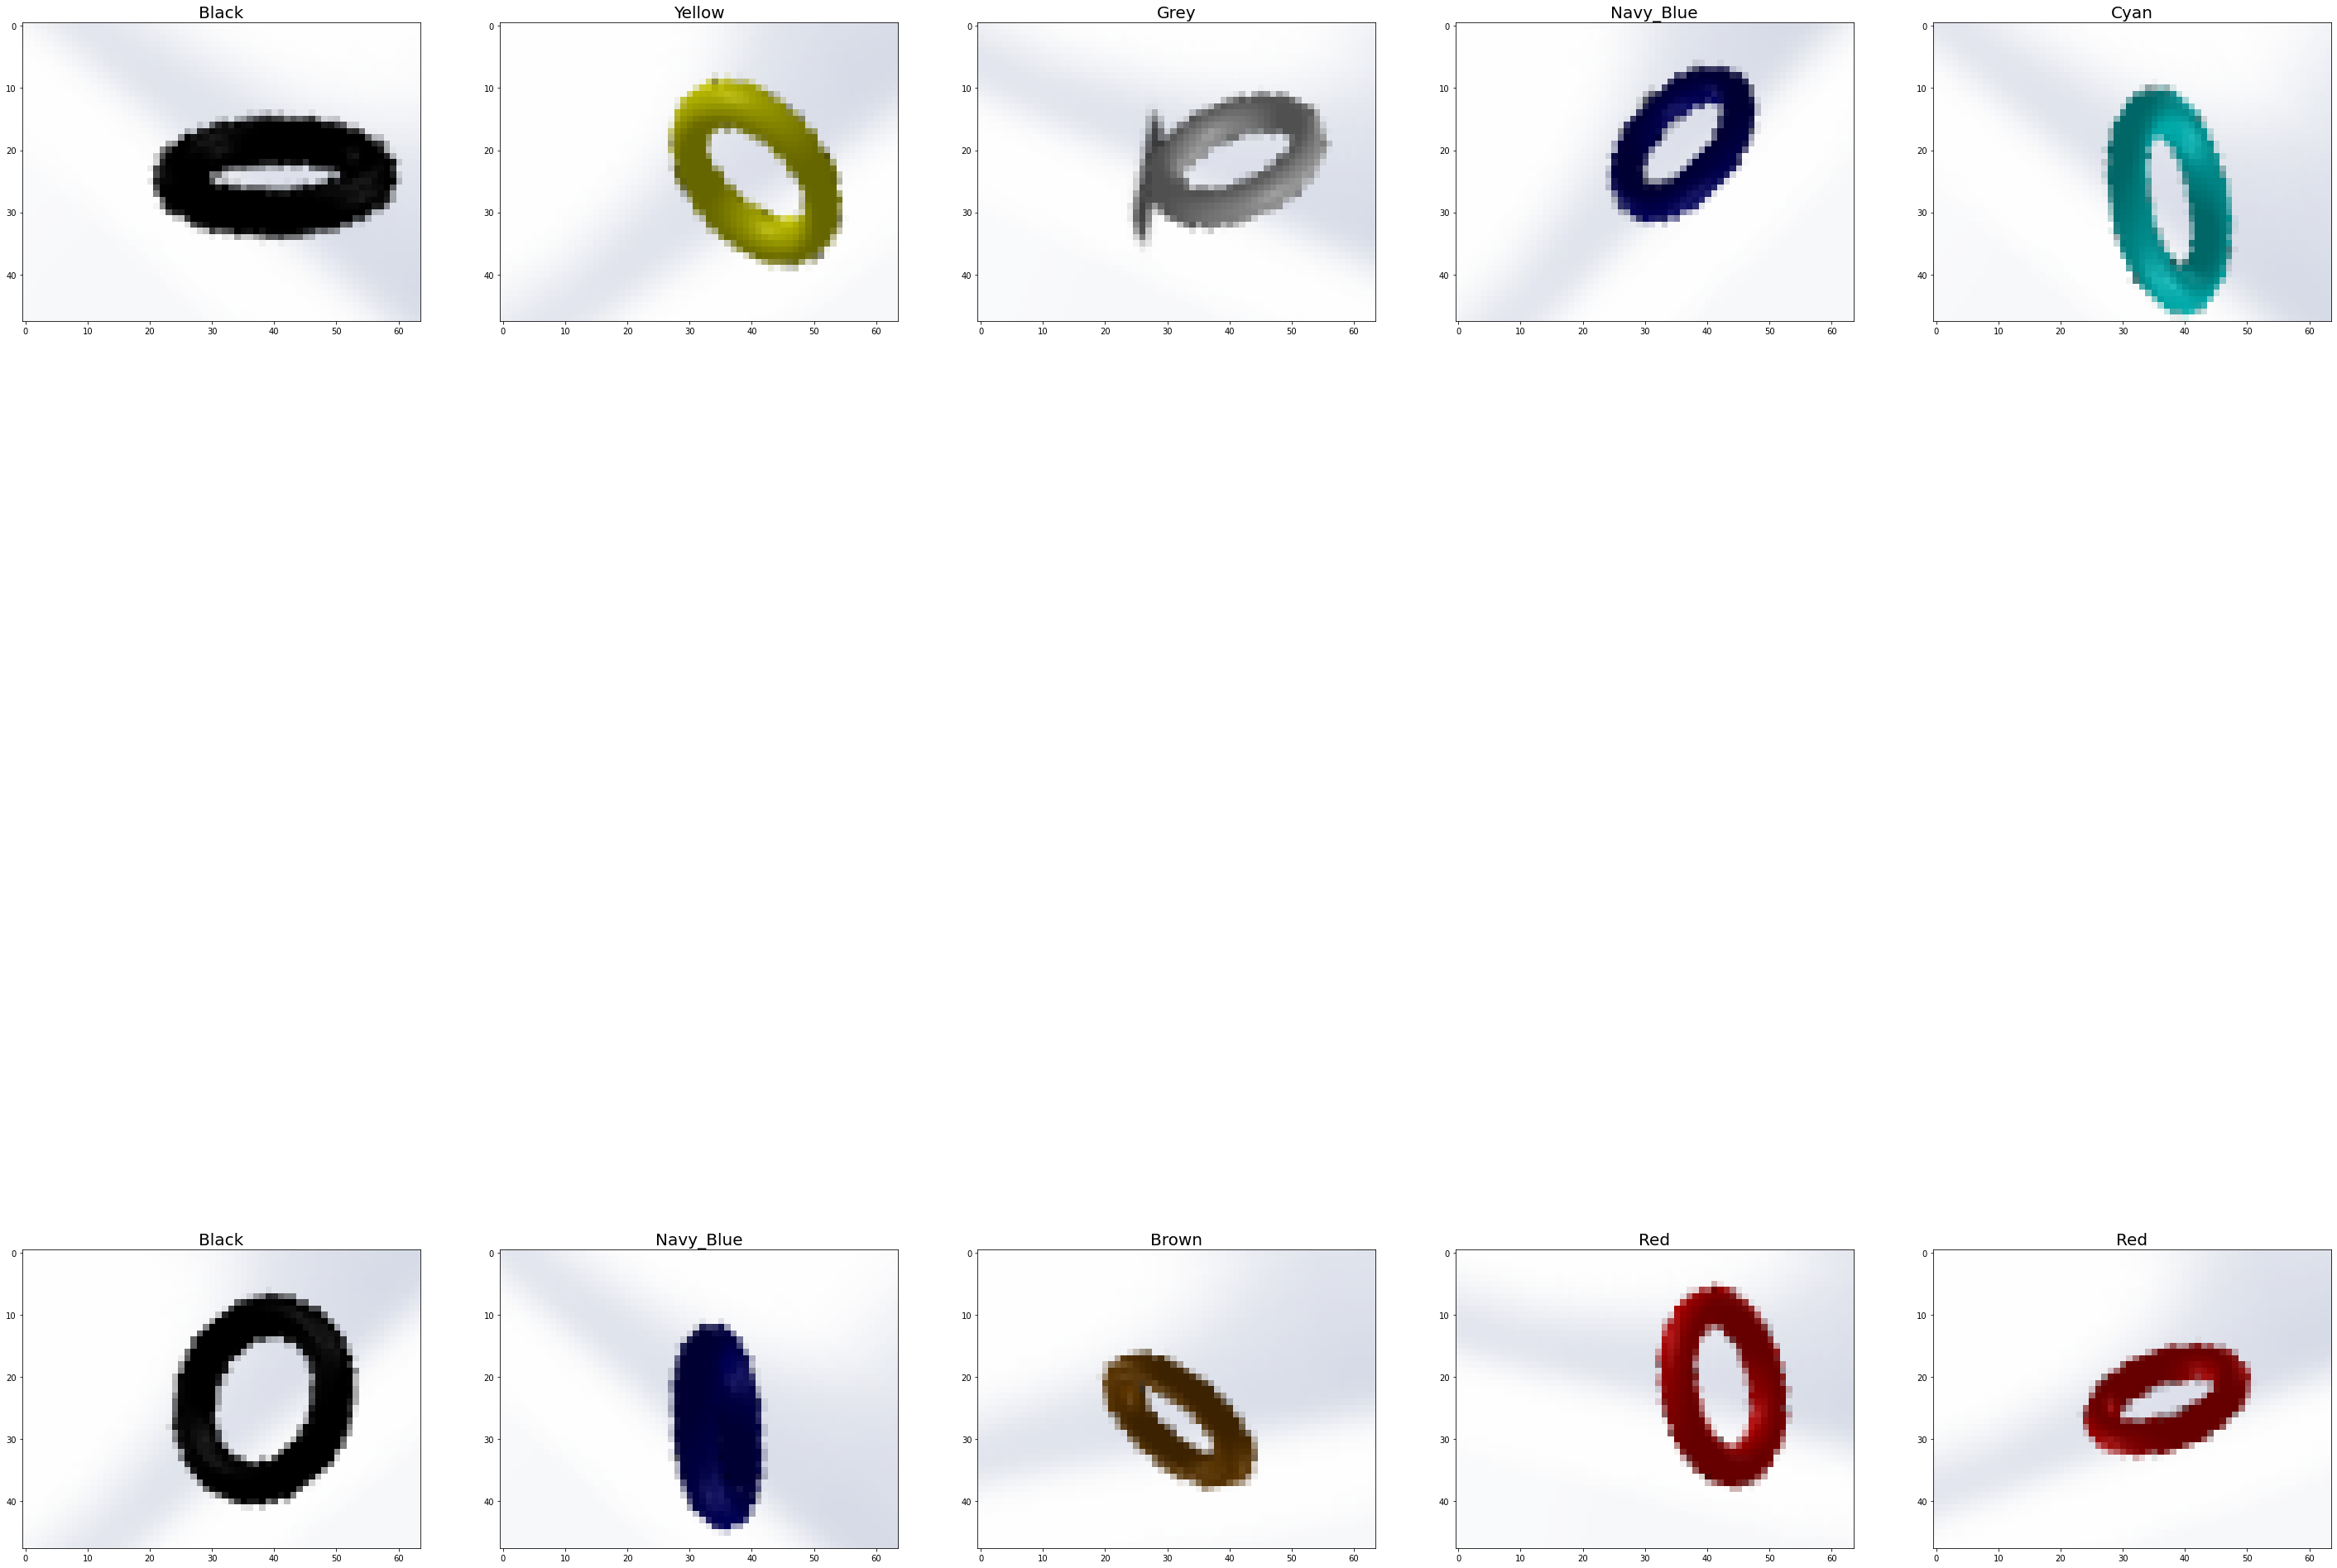

In [15]:
fig=plt.figure(figsize=(50,50))   
for i in range(10):
  startind=120
  sub=fig.add_subplot(2,5,i+1)
  img=X_train[i+startind].copy()
  #img=img.reshape((h,b))
  sub.imshow(cv2.cvtColor(img.astype(np.uint8),cv2.COLOR_BGR2RGB))
  #temp=y_train[i]
  plt.title(colours[int(y_train[i+startind])],fontsize=20)        
plt.show()

# Building and training the model

In [16]:
X_train=X_train/255.0
X_valid=X_valid/255.0

In [20]:
inputs=tf.keras.Input(shape=(h,b,3))

x=Conv2D(16,3,1,padding='same',activation='relu')(inputs)
x=MaxPool2D(2,2,padding='valid')(x)

x=Conv2D(32,3,1,padding='same',activation='relu')(x)
x=BatchNormalization()(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Conv2D(64,3,1,padding='same',activation='relu')(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Conv2D(128,3,1,padding='same',activation='relu')(x)
x=MaxPool2D(2,2,padding='valid')(x)

x=Flatten()(x)
output=Dense(8,activation='softmax')(x)

model=tf.keras.Model(inputs,output,name='model1b')

model.compile(optimizer='adagrad',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "model1b"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 64, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 64, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 32, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 32, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 32, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 16, 64)        1849

In [21]:
epochs=10
history=model.fit(X_train,
                  y_train,
                  batch_size=32,
                  epochs=epochs,
                  validation_data=(X_valid,y_valid))

Epoch 1/10
2000/2000 [==============================] - 8s 4ms/step - loss: 0.1319 - accuracy: 0.9790 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 2/10
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 3/10
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/10
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 5/10
2000/2000 [==============================] - 7s 4ms/step - loss: 9.7722e-04 - accuracy: 1.0000 - val_loss: 8.1082e-04 - val_accuracy: 1.0000
Epoch 6/10
2000/2000 [==============================] - 7s 4ms/step - loss: 7.6763e-04 - accuracy: 1.0000 - val_loss: 6.5500e-04 - val_accuracy: 1.0000
Epoch 7/10
2000/2000 [==============================] - 7s 4ms/step - loss: 6.2468e-04 - accuracy: 1.0000 - val_loss: 5.

Text(0.5, 1.0, 'Training and Validation Accuracy')

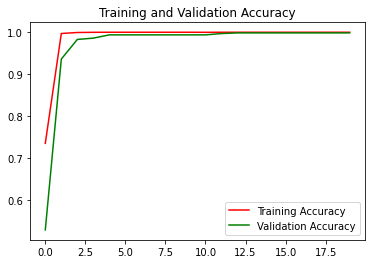

In [7]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs_range=range(epochs)
plt.plot(epochs_range, acc, label='Training Accuracy',color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy',color='green')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
predictions=model.predict(X_valid).astype(float)
tf.math.confusion_matrix(y_valid.reshape(len(y_valid),),np.argmax(predictions,axis=1))

<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[80,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 80,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 78,  0,  0,  0,  0,  2],
       [ 0,  0,  0, 80,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 80,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 79,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 76,  4],
       [ 0,  0,  0,  0,  0,  0,  0, 80]], dtype=int32)>

In [22]:
model.save("model1b_10000.h5")